# ACS 5-Year 2022 PUMS

In [1]:
!pip install requests
import requests
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


In [22]:
api_key = "6078902264e70157fe238f0803785bf79dd9f921"
url_1 = f"https://api.census.gov/data/2022/acs/acs5/pums?get=RAC1P,SCHL,PWGTP,PUMA20&for=state:04&key={api_key}"

In [23]:
response_1 = requests.get(url_1)
if response_1.status_code == 200:
    data_1 = response_1.json()
    # Convert JSON data to a DataFrame
    headers_1 = data_1[0]
    rows_1 = data_1[1:]
    full_data = pd.DataFrame(rows_1, columns=headers_1)
else:
    print(f"Failed to fetch data from URL 1: {response_1.status_code}")


In [24]:
full_data[['RAC1P', 'SCHL', 'PWGTP','PUMA20','state,']] = full_data[['RAC1P', 'SCHL', 'PWGTP','PUMA20','state']].apply(pd.to_numeric)

# Display first few rows
print('head')
print(full_data.head())

# Get DataFrame info (columns, non-null counts, etc.)
print('info')
full_data.info()

# Describe numerical data
print('describe')
print(full_data.describe())

# Check for missing data
print('missing data')
print(full_data.isnull().sum())

head
   RAC1P  SCHL  PWGTP  PUMA20 state  state,
0      1    16      3      -9    04       4
1      1    11      5      -9    04       4
2      1    12     14      -9    04       4
3      1    14      5      -9    04       4
4      1    16     15      -9    04       4
info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341258 entries, 0 to 341257
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   RAC1P   341258 non-null  int64 
 1   SCHL    341258 non-null  int64 
 2   PWGTP   341258 non-null  int64 
 3   PUMA20  341258 non-null  int64 
 4   state   341258 non-null  object
 5   state,  341258 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 15.6+ MB
describe
               RAC1P           SCHL          PWGTP         PUMA20    state,
count  341258.000000  341258.000000  341258.000000  341258.000000  341258.0
mean        2.684233      15.838852      21.017183     130.410308       4.0
std         2.932872       6.123

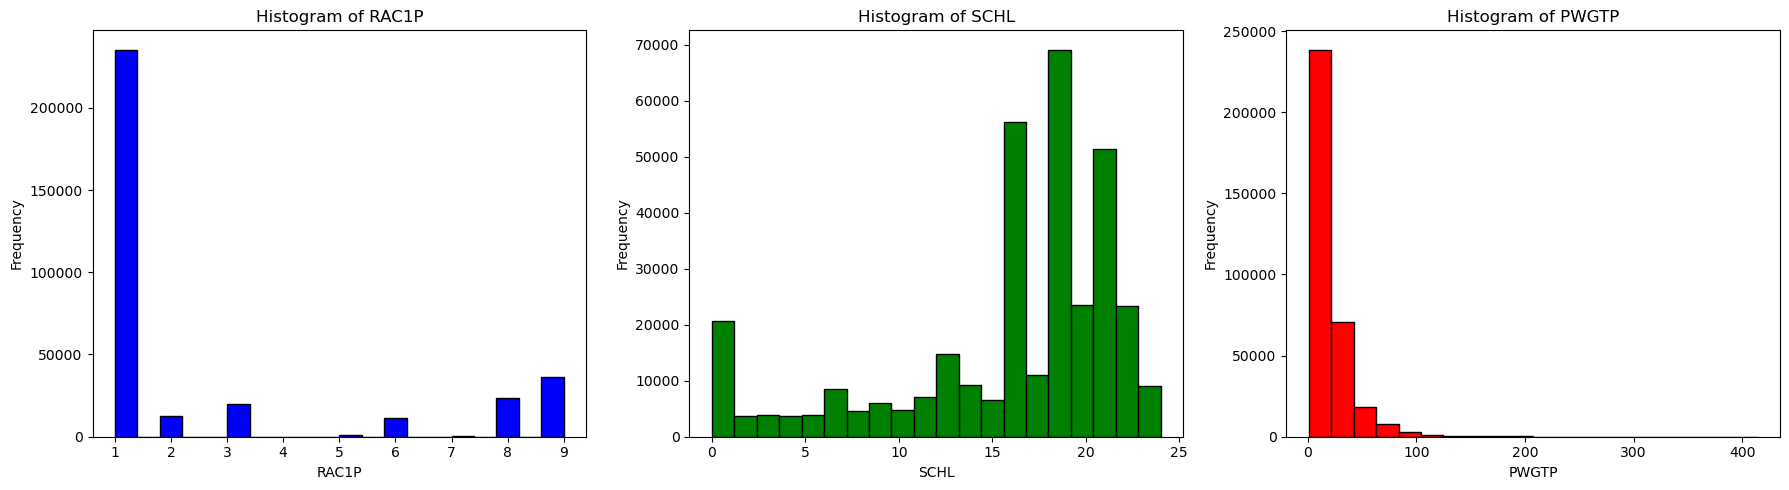

In [25]:
# Create histograms for RAC1P, SCHL, and PWGTP
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for RAC1P
axes[0].hist(full_data['RAC1P'], bins=20, color='blue', edgecolor='black')
axes[0].set_title('Histogram of RAC1P')
axes[0].set_xlabel('RAC1P')
axes[0].set_ylabel('Frequency')

# Histogram for SCHL
axes[1].hist(full_data['SCHL'], bins=20, color='green', edgecolor='black')
axes[1].set_title('Histogram of SCHL')
axes[1].set_xlabel('SCHL')
axes[1].set_ylabel('Frequency')

# Histogram for PWGTP
axes[2].hist(full_data['PWGTP'], bins=20, color='red', edgecolor='black')
axes[2].set_title('Histogram of PWGTP')
axes[2].set_xlabel('PWGTP')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Data handing

## 1. Compute PUMA-Level Consolidation (`compute_consolidation_by_puma`)

Function Called:
`compute_consolidation_by_puma(df, puma_col='PUMA20')`

 Data Grouping

* The function groups the DataFrame by `PUMA` and `state`. Each group represents individuals within a specific PUMA-state combination.

 Population Size Calculation

* For each group, the total population size (`n`) is calculated by summing person weights (PWGTP).

 Weighted Contingency Table Creation

* `build_weighted_contingency_table` is called to create a weighted contingency table for race (`RAC1P`) and education (`SCHL`), with weights applied via PWGTP.

 Cramér’s V Calculation

* `calculate_cramers_v` is called with the contingency table and population size to compute the consolidation measure (Cramér's V). This score reflects the degree of association between race and education for each PUMA.

Storing Results

* The PUMA identifier, state, and consolidation measure are stored in a new DataFrame.

Return Results

* A DataFrame containing PUMA-level consolidation scores is returned for analysis.



## Data Flow for build_weighted_contingency_table
Function Called:
* `build_weighted_contingency_table(df, race_col='RAC1P', edu_col='SCHL', weight_col='PWGTP')`

Extract Column Values

* Converts race, education, and person weight columns to NumPy arrays for efficient processing.
Generate Mappings for Categories

* Creates mappings from unique race and education categories to row and column indices in a sparse matrix.
Build Sparse Matrix

* Constructs a sparse matrix with person weights representing the count of individuals for each race-education pair.
Return Matrix and Dimensions

* Returns the contingency matrix, along with the number of race and education categories.
## Data Flow for calculate_cramers_v
Function Called:
`calculate_cramers_v(contingency_matrix, n, num_races, num_educations)`

Convert to Dense Matrix

* Converts the sparse contingency matrix to a dense array for easier calculations.
Compute Row and Column Sums

* Calculates the row and column sums, representing marginal totals for race and education.
Calculate Expected Frequencies

* Uses the outer product of row and column sums to compute the expected frequency under the assumption of independence.
Compute Chi-Squared Statistic

* Calculates the chi-squared statistic by comparing observed and expected frequencies.
Calculate Cramér’s V

* Normalizes the chi-squared statistic using degrees of freedom and population size to produce the Cramér’s V score.
Return Result

* Returns the Cramér’s V score. If any calculation is invalid, it returns NaN.
## Compute Tract-Level Consolidation (compute_tract_level_consolidation)
Function Called:
`compute_tract_level_consolidation(df)`

Generate Synthetic Tracts

* generate_synthetic_tracts is called to divide individuals within each PUMA into synthetic tracts for tract-level analysis.
Group by Synthetic Tracts, PUMA, and State

* The DataFrame is grouped by synthetic_tract, PUMA, and state to create distinct units for consolidation measurement.
Calculate Population Size

* For each synthetic tract, the total population size (n) is computed by summing PWGTP.
Create Weighted Contingency Table

* `build_weighted_contingency_table` is called to build a contingency matrix for race and education within each synthetic tract.
Calculate Cramér’s V for Tracts

* `calculate_cramers_v` is called to compute the consolidation measure for each synthetic tract.
Store Results

* The results (synthetic tract ID, PUMA, state, and consolidation measure) are stored in a DataFrame.
Return Results

A DataFrame with tract-level consolidation measures is returned.
## Data Flow for generate_synthetic_tracts
Function Called:
`generate_synthetic_tracts(df, puma_col='PUMA20', num_tracts=1, random_state=None)`

Set Random Seed

* If a random_state is provided, it is used to ensure reproducibility when shuffling individuals.
Pre-allocate Array for Tracts

* Initializes an empty NumPy array to store synthetic tract identifiers.
Shuffle Individuals within Each PUMA

* For each PUMA, individuals are shuffled randomly using np.random.permutation.
Assign Tract Identifiers

* Synthetic tract IDs are assigned cyclically to ensure a balanced distribution.
Return DataFrame

The original DataFrame is returned with an additional column for synthetic tract identifiers.
## Summary of Data Flow
1. `compute_consolidation_by_puma`:

* Groups data by PUMA and state → Creates weighted contingency tables → Computes Cramér’s V for each PUMA → Returns PUMA-level consolidation scores.
2. `compute_tract_level_consolidation`:

* Generates synthetic tracts → Groups data by tract, PUMA, and state → Creates contingency tables for each group → Computes Cramér’s V → Returns tract-level consolidation scores.
3. Supporting Functions:

* `build_weighted_contingency_table`: Constructs a sparse matrix of person weights across race and education categories.
* `calculate_cramers_v`: Computes the degree of association between race and education.
* `generate_synthetic_tracts`: Randomly assigns individuals within each PUMA to synthetic tracts for finer-grained analysis.

In [41]:
def build_weighted_contingency_table(df, race_col, edu_col, weight_col):
    """
    Build a weighted contingency table for race and education using sparse matrices.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing individual-level data, including race, education, 
        and person weights.
    race_col : str
        The column name representing race/ethnicity categories.
    edu_col : str
        The column name representing education attainment categories.
    weight_col : str
        The column name representing person weights (PWGTP).

    Returns:
    --------
    contingency_matrix : scipy.sparse.csr_matrix
        A sparse matrix representing the weighted contingency table.
    num_races : int
        The number of unique race categories.
    num_educations : int
        The number of unique education categories.

    Description:
    ------------
    This function constructs a weighted contingency table that summarizes the 
    relationship between race and education. It uses sparse matrices to efficiently 
    store and manipulate data. The table cells contain the sum of person weights 
    corresponding to each race-education pair.
    """
    races = df[race_col].astype(int).values
    educations = df[edu_col].astype(int).values
    weights = df[weight_col].astype(float).values

    unique_races = np.unique(races)
    unique_educations = np.unique(educations)

    # Create mappings for index conversion
    race_to_idx = {val: idx for idx, val in enumerate(unique_races)}
    edu_to_idx = {val: idx for idx, val in enumerate(unique_educations)}

    # Build sparse matrix
    row_indices = np.array([race_to_idx[r] for r in races])
    col_indices = np.array([edu_to_idx[e] for e in educations])

    contingency_matrix = csr_matrix(
        (weights, (row_indices, col_indices)),
        shape=(len(unique_races), len(unique_educations))
    )
    return contingency_matrix, len(unique_races), len(unique_educations)

def calculate_cramers_v(contingency_matrix, n, num_races, num_educations):
    """
    Calculate Cramér's V using the weighted contingency matrix.

    Parameters:
    -----------
    contingency_matrix : scipy.sparse.csr_matrix
        The weighted contingency matrix for race and education categories.
    n : float
        The total population size (sum of person weights) for the group.
    num_races : int
        The number of unique race categories.
    num_educations : int
        The number of unique education categories.

    Returns:
    --------
    float
        The Cramér's V score, representing the degree of association between 
        race and education. Returns NaN if the calculation is invalid.

    Description:
    ------------
    Cramér's V measures the strength of association between two categorical variables 
    (in this case, race and education). The function first computes the expected 
    frequencies under independence, then calculates the chi-squared statistic. 
    The statistic is normalized by the population size and degrees of freedom 
    to return Cramér's V, a value between 0 (no association) and 1 (perfect association).
    """
    observed = contingency_matrix.toarray()
    row_sums = observed.sum(axis=1)
    col_sums = observed.sum(axis=0)

    expected = np.outer(row_sums, col_sums) / n
    with np.errstate(divide='ignore', invalid='ignore'):
        chi2_stat = np.nansum((observed - expected) ** 2 / expected)

    denominator = n * min(num_races - 1, num_educations - 1)
    if denominator <= 0 or chi2_stat < 0:
        return np.nan
    return np.sqrt(chi2_stat / denominator)

def compute_consolidation_by_puma(df, puma_col='PUMA20'):
    """
    Compute PUMA-level consolidation for the most recent year.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing individual-level data, including race, education, 
        person weights, and PUMA identifiers.
    puma_col : str, optional (default='PUMA20')
        The column name representing the PUMA identifier.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the PUMA identifier, state, and the corresponding 
        consolidation measure (Cramér's V).

    Description:
    ------------
    This function calculates consolidation (Cramér's V) at the PUMA level by grouping 
    individuals by PUMA and state. For each PUMA, it builds a weighted contingency table 
    and computes the consolidation score. This measure helps identify the alignment 
    between race and education within large geographic areas.
    """
    results = []
    grouped = df.groupby([puma_col, 'state'])

    for (puma, state), group in grouped:
        n = group['PWGTP'].sum()
        contingency_matrix, num_races, num_educations = build_weighted_contingency_table(
            group, 'RAC1P', 'SCHL', 'PWGTP'
        )
        if num_races > 1 and num_educations > 1:
            consolidation = calculate_cramers_v(contingency_matrix, n, num_races, num_educations)
        else:
            consolidation = np.nan
        results.append({'PUMA20': puma, 'State': state, 'Consolidation': consolidation})
    return pd.DataFrame(results)

def generate_synthetic_tracts(df, puma_col='PUMA20', num_tracts=1, random_state=None):
    """
    Assign synthetic tract identifiers within each PUMA using randomized assignment.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing individual-level data, including PUMA identifiers.
    puma_col : str, optional (default='PUMA20')
        The column name representing the PUMA identifier.
    num_tracts : int, optional (default=1)
        The number of synthetic tracts to create per PUMA.
    random_state : int, optional (default=None)
        Seed for reproducible shuffling. Set to None for random behavior.

    Returns:
    --------
    pandas.DataFrame
        The original DataFrame with an additional 'synthetic_tract' column.

    Description:
    ------------
    This function assigns synthetic tract identifiers within each PUMA by shuffling 
    the order of individuals before dividing them into tracts. This ensures a more 
    randomized distribution across tracts, simulating finer-grained analysis. The 
    function is optimized to handle large datasets efficiently using NumPy operations.
    """
    np.random.seed(random_state)  # Set the random seed for reproducibility if specified

    # Create a new column for synthetic tract assignment
    synthetic_tracts = np.zeros(len(df), dtype=int)  # Pre-allocate array for efficiency

    # Group by PUMA and assign shuffled tract identifiers
    for __, group_indices in df.groupby(puma_col).groups.items():
        # Shuffle the indices of individuals within the PUMA
        shuffled_indices = np.random.permutation(group_indices)

        # Assign tract IDs in a cyclic manner
        synthetic_tracts[shuffled_indices] = np.arange(len(shuffled_indices)) % num_tracts

    # Add the synthetic tract assignments to the DataFrame
    df['synthetic_tract'] = synthetic_tracts

    return df

def compute_tract_level_consolidation(df):
    """
    Compute tract-level consolidation by merging multiple years of data.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing individual-level data, including race, education, 
        person weights, and PUMA identifiers.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the synthetic tract identifier, PUMA, state, and 
        the corresponding consolidation measure (Cramér's V).

    Description:
    ------------
    This function calculates tract-level consolidation by first generating synthetic 
    tract identifiers and then grouping individuals by these identifiers, along with 
    PUMA and state. For each synthetic tract, it builds a weighted contingency table 
    and computes the consolidation score (Cramér's V). This method approximates 
    tract-level analysis and prepares the workflow for integration with real 
    tract-level data in the future.
    """
    num_tracts_var = round(len(full_data)/4000)             # Average number of tracts by population size
    df = generate_synthetic_tracts(df,puma_col='PUMA20', num_tracts=num_tracts_var )
    results = []

    grouped = df.groupby(['synthetic_tract', 'PUMA20', 'state'])

    for (tract, puma, state), group in grouped:
        n = group['PWGTP'].sum()
        contingency_matrix, num_races, num_educations = build_weighted_contingency_table(
            group, 'RAC1P', 'SCHL', 'PWGTP'
        )
        if num_races > 1 and num_educations > 1:
            consolidation = calculate_cramers_v(contingency_matrix, n, num_races, num_educations)
        else:
            consolidation = np.nan
        results.append({
            'Tract': tract, 'PUMA20': puma, 'State': state, 'Consolidation': consolidation
        })
    return pd.DataFrame(results)


# Execute

In [42]:
test_df = full_data.copy()      # Adjust for smaller samples of full data  
puma_consolidation = compute_consolidation_by_puma(test_df)
tract_consolidation = compute_tract_level_consolidation(test_df)
puma_consolidation.head(), tract_consolidation.head()

(   PUMA20 State  Consolidation
 0      -9    04       0.087852
 1     101    04       0.154024
 2     102    04       0.206274
 3     103    04       0.223181
 4     104    04       0.213946,
    Tract  PUMA20 State  Consolidation
 0      0      -9    04       0.148646
 1      0     101    04       0.634234
 2      0     102    04       0.640251
 3      0     103    04       0.753205
 4      0     104    04       0.871423)

## Data observation

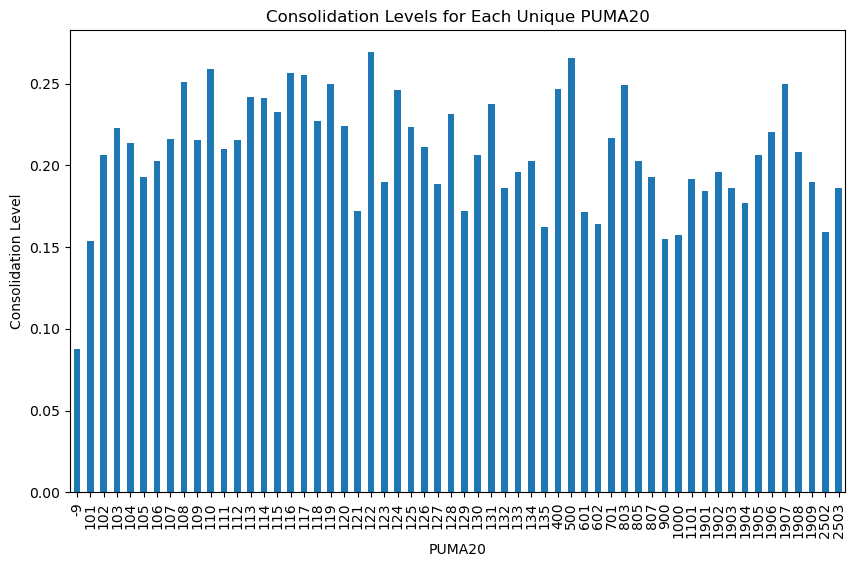

In [43]:
# Plot the bar chart
average_consolidation_puma = puma_consolidation.groupby('PUMA20')['Consolidation'].mean()
average_consolidation_puma.plot(kind='bar', figsize=(10, 6))
plt.xlabel('PUMA20')
plt.ylabel('Consolidation Level')
plt.title('Consolidation Levels for Each Unique PUMA20')
plt.show()

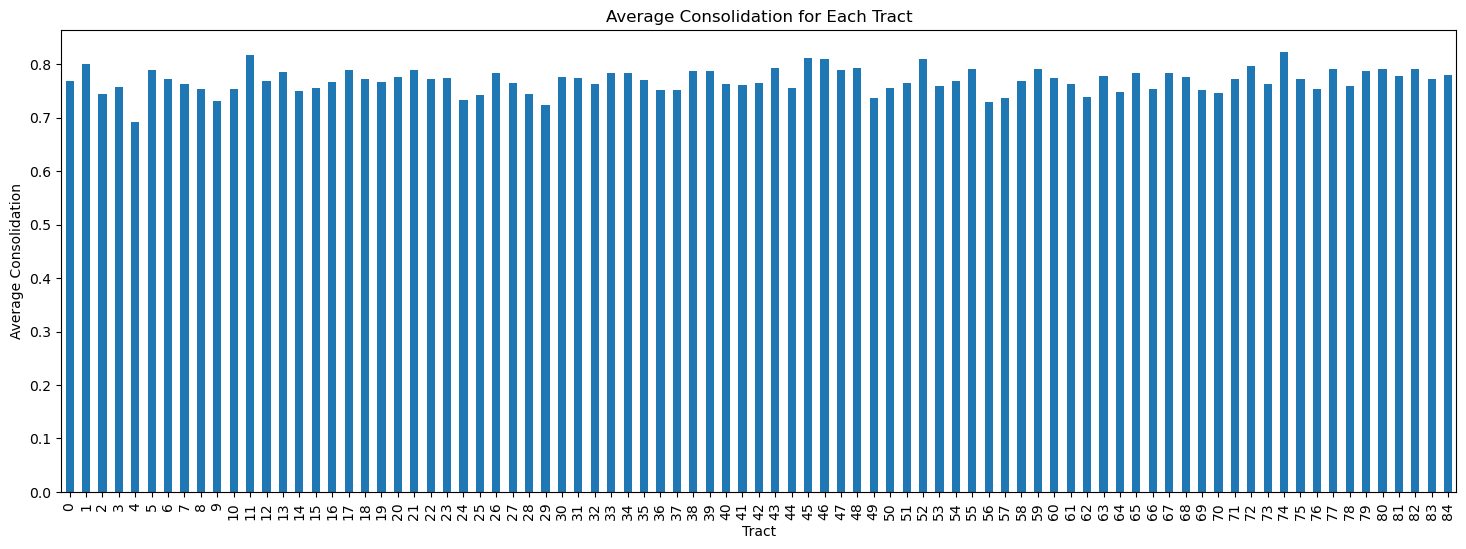

In [44]:
# Calculate the average consolidation for each tract
average_consolidation_TRACT = tract_consolidation.groupby('Tract')['Consolidation'].mean()

# Plot the bar chart
average_consolidation_TRACT.plot(kind='bar', figsize=(18, 6))
plt.xlabel('Tract')
plt.ylabel('Average Consolidation')
plt.title('Average Consolidation for Each Tract')
plt.show()